# Drought analysis from Brun et al.

In [23]:
import geopandas as gpd
import fiona
from rasterio.mask import mask
from shapely.geometry import box
import json
import os
import re
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from shapely import wkt

## Open raster in a window where browning polygons found

In [24]:
bbox_nodrought =  [6.44727, 46.65440, 6.45514, 46.66093] #[6.4309, 46.67719, 6.43851, 46.68224]#[6.3837, 46.6623, 6.4005, 46.6755]
coords = "46.630_6.379_47.700_6.507"
#bbox = bbox_nodrought


# Vaud
bbox_browning =  [6.4953, 46.664, 6.4965, 46.6655] #[6.49323, 46.66315, 6.498519, 46.66671] #[6.48650, 46.66451, 6.49702, 46.67012]
coords = "46.630_6.379_47.700_6.507"
bbox = bbox_browning
"""

bbox_browning =  [8.64029,47.72969, 8.64370, 47.73234] 
coords = "47.586_8.397_47.807_8.756" # Schaffhausen
bbox = bbox_browning


bbox_grench = [7.3662, 47.2000, 7.4033, 47.2200]
coords = "46.907_7.137_47.407_7.637" # Jura
bbox = bbox_grench
"""

'\n\nbbox_browning =  [8.64029,47.72969, 8.64370, 47.73234] \ncoords = "47.586_8.397_47.807_8.756" # Schaffhausen\nbbox = bbox_browning\n\n\nbbox_grench = [7.3662, 47.2000, 7.4033, 47.2200]\ncoords = "46.907_7.137_47.407_7.637" # Jura\nbbox = bbox_grench\n'

In [25]:
# CREATE FOREST MASK AND GET COORDINATES OF FOREST PIXELS

forest_threshold = 0.95 #ratio of forest per pixel

# Create forest mask --> Use the one in valais!
forest_mask = f'/dccstor/cimf/drought_impact/downloads/forest_mask/{coords}/Drought-Continuous forest mask-11_03_2022T00_00_00.tiff'
if bbox is not None:
    with rasterio.open(forest_mask) as src:
        im_forest = rasterio.open(forest_mask)
    for_arr = im_forest.read(1,  window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
else:
    with rasterio.open(forest_mask) as src:
        im_forest = rasterio.open(forest_mask)
    for_arr = im_forest.read(1)

for_arr[for_arr==-9999] = np.nan

# Make binary mask keeping only pixels that are >50% forest
forest_binary = for_arr.copy()
forest_binary[np.isnan(forest_binary)]=0
forest_binary[forest_binary<forest_threshold]=0
forest_binary[forest_binary!=0]=1
forest_binary = (forest_binary==1)

# Get coordinates of forest pixel in bbox
with rasterio.open(forest_mask) as src:
    im_forest = rasterio.open(forest_mask)
    for_arr = im_forest.read(1,  window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
    print('shape of bbox:', for_arr.shape)
    height = for_arr.shape[0]
    width = for_arr.shape[1]
    bbox_transform = rasterio.transform.from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], width, height)
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(bbox_transform, rows, cols)
    lons = np.concatenate(xs).ravel()
    lats = np.concatenate(ys).ravel()

# Select forest pixels
forest_indices = np.where(forest_binary.flatten() == True)
row_pixs = forest_indices[0]
col_pixs = forest_indices[0]
lons = lons[col_pixs]
lats = lats[row_pixs]

df_coords = pd.DataFrame({'lons':lons, 'lats': lats})

# Create point geometries
gdf = gpd.GeoDataFrame(df_coords, geometry=gpd.points_from_xy(df_coords['lons'], df_coords['lats']), crs="EPSG:4326")

shape of bbox: (6, 5)


In [26]:
def get_ndvi_and_bands_coords(coords, forest_binary, bbox, gdf):
    """
    Get NDVI pixels in bounding box if cloud proba < cp_thresh, sampling only forest pixels using the firet mask
    :param coords: coords of Valais patch to filter folders
    :param cp_thresh: cloud proba threshold. Drop measurement if its proba is above 
    :param gdf: GeoDataFrae containing cooridnates of all forest pixels in bbox
    :param forest_binary: forest mask
    :param bbox: boudning box to read data from
    """
    
    data_path = '/dccstor/cimf/drought_impact/downloads/SENTINEL 2'
    df_NDVI = pd.DataFrame()

    for folder in os.listdir(data_path):
        if coords in folder:
            timestamp = datetime.strptime(folder.split('Z')[0], '%Y-%m-%dT%H:%M:%S')
            for file in os.listdir(data_path + '/' + folder):

                ndvi_search = '\[' +  'NDVI' + '\]'
                cp_search =  '\[' + 'CP' + '\]'
                b2_search = '\[' + 'B02' + '\]'
                b8_search = '\[' + 'B08' + '\]'

                if (file.endswith('.tiff') & bool(re.search(f'{ndvi_search}',file))): 
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        ndvi = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))

                if (file.endswith('.tiff') & bool(re.search(f'{cp_search}',file))): 
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        cloud = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
                
                if (file.endswith('.tiff') & bool(re.search(f'{b2_search}',file))): 
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        b2 = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
                
                if (file.endswith('.tiff') & bool(re.search(f'{b8_search}',file))): 
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        b8 = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
                        
                        
            # Mask out forest, clouds and -9999 (as nan)
            cloud[cloud == -9999] = np.nan
            ndvi[ndvi == -9999] = np.nan
            b2[b2 == -9999] = np.nan
            b8[b8 == -9999] = np.nan

            df_file = pd.DataFrame({'timestamp': [timestamp]*len(ndvi[forest_binary].flatten()), 'ndvi': ndvi[forest_binary].flatten(), 
                                    'cp':cloud[forest_binary].flatten(), 'b2':b2[forest_binary].flatten(), 'b8':b8[forest_binary].flatten(), coords:gdf.geometry}) 
            df_file = df_file.dropna(axis=0)
            
            df_NDVI = pd.concat([df_NDVI, df_file], axis=0, ignore_index=True) 

    return df_NDVI

In [183]:
df_NDVI = get_ndvi_and_bands_coords(coords, forest_binary, bbox, gdf)
df_NDVI['year'] = df_NDVI['timestamp'].dt.year
df_NDVI['day'] = df_NDVI['timestamp'].dt.dayofyear
df_NDVI = df_NDVI.rename(columns={f'{coords}':'coords'})
df_NDVI['month'] = df_NDVI['timestamp'].dt.month
df_NDVI['wkt'] = df_NDVI.coords.apply(lambda x: x.to_wkt())

KeyboardInterrupt: 

In [27]:
df_NDVI_brown = get_ndvi_and_bands_coords(coords, forest_binary, bbox, gdf)
df_NDVI_brown['year'] = df_NDVI_brown['timestamp'].dt.year
df_NDVI_brown['day'] = df_NDVI_brown['timestamp'].dt.dayofyear
df_NDVI_brown['month'] = df_NDVI_brown['timestamp'].dt.month
df_NDVI_brown = df_NDVI_brown.rename(columns={f'{coords}':'coords'})
df_NDVI_brown['wkt'] = df_NDVI_brown.coords.apply(lambda x: x.wkt)

# Compare drought vs non drought 2018

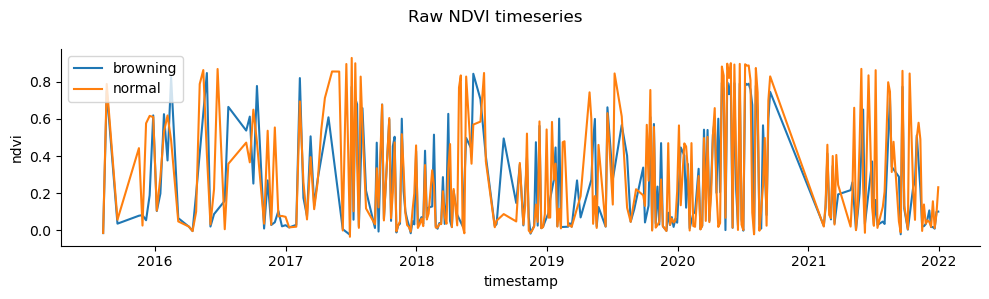

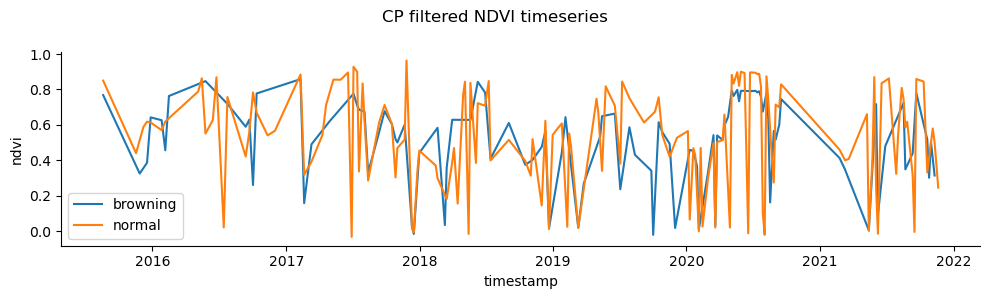

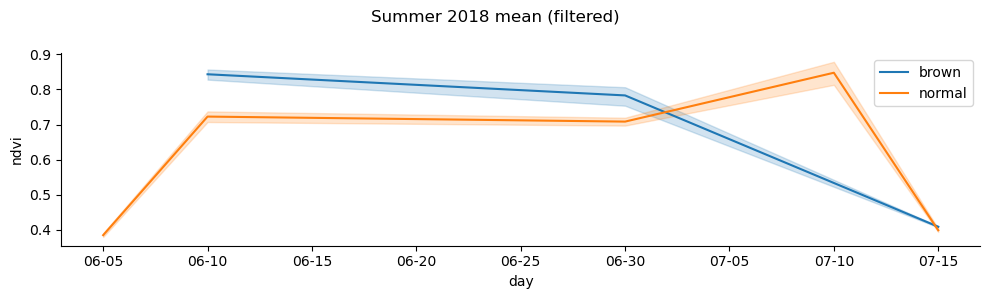

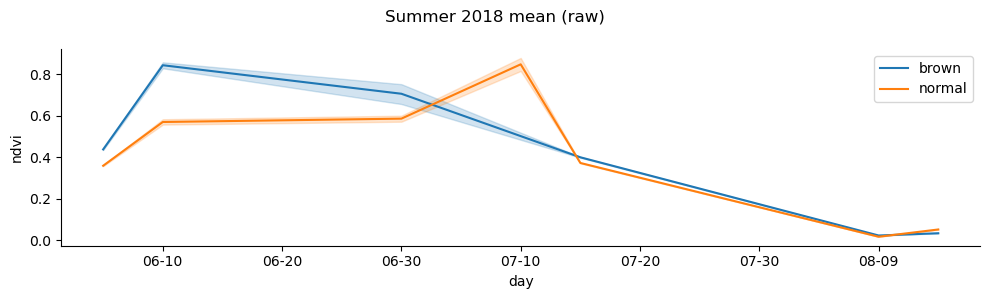

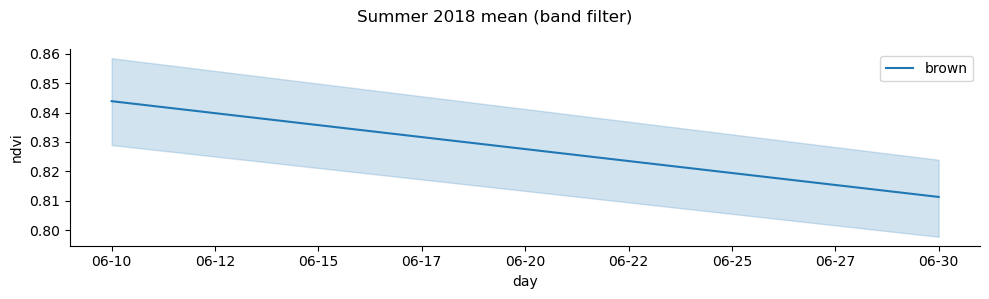

In [62]:
# BROWNING: mean of points browning vs no browning

df_brown = df_NDVI_brown.groupby('timestamp').mean().reset_index()
df_non = df_NDVI.groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='browning')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_non, label='normal')
sns.despine(top=True, right=True)
plt.tight_layout()

df_brown = df_NDVI_brown[df_NDVI_brown.cp<1].groupby('timestamp').mean().reset_index()
df_non = df_NDVI[df_NDVI.cp<1].groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('CP filtered NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='browning')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_non, label='normal')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer 2018 mean (filtered)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.cp<1) & (df_NDVI_brown.year.isin([2018]))  & (df_NDVI_brown.month.isin([6,7,8]))], label='brown')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.cp<1) & (df_NDVI.year.isin([2018]))  & (df_NDVI.month.isin([6,7,8]))], label='normal')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer 2018 mean (raw)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.year.isin([2018]))  & (df_NDVI_brown.month.isin([6,7,8]))], label='brown')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.year.isin([2018]))  & (df_NDVI.month.isin([6,7,8]))], label='normal')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer 2018 mean (band filter)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI_brown[((df_NDVI_brown.b2<0.1) & (df_NDVI_brown.b8>0.15)) & (df_NDVI_brown.year.isin([2018]))  & (df_NDVI_brown.month.isin([6,7,8]))], label='brown')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[((df_NDVI_brown.b2<0.1) & (df_NDVI_brown.b8>0.15)) & (df_NDVI.year.isin([2018]))  & (df_NDVI.month.isin([6,7,8]))], label='normal')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

### Compare 2017 and 2018 for browning area

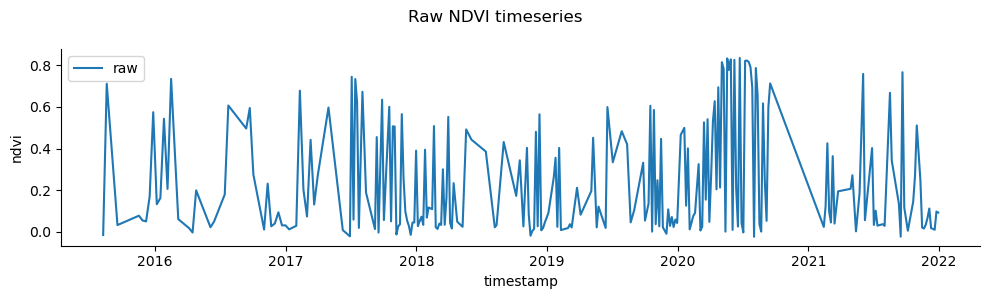

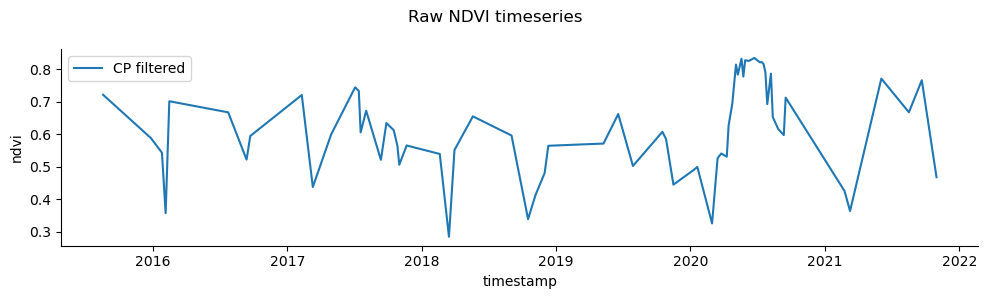

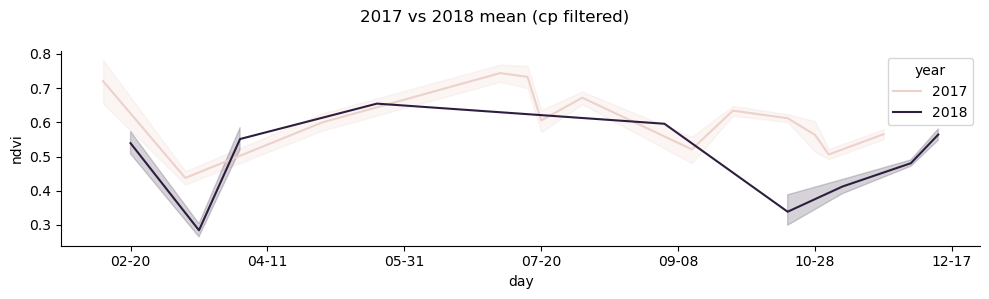

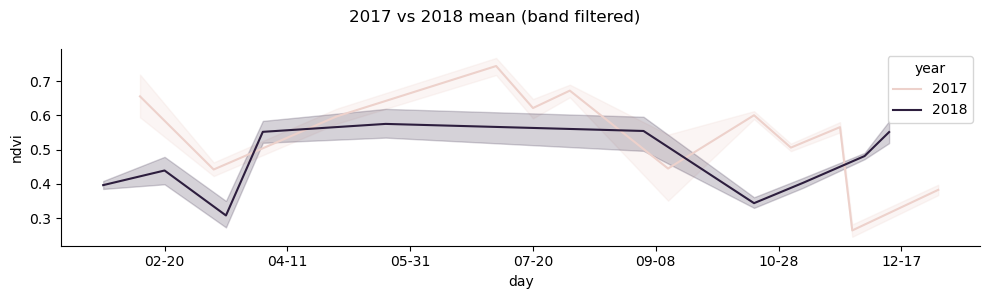

In [7]:
# BROWNING: mean of points browning vs no browning
df_brown = df_NDVI_brown.groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='raw')
sns.despine(top=True, right=True)
plt.tight_layout()

df_brown = df_NDVI_brown[(df_NDVI_brown.cp<1) & (df_NDVI_brown.b2<0.1)].groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='CP filtered')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 mean (cp filtered)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.cp<1) & (df_NDVI_brown.b2<0.1) & (df_NDVI_brown.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 mean (band filtered)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI_brown[((df_NDVI_brown.b2<0.1) & (df_NDVI_brown.b8>0.15)) & (df_NDVI_brown.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

## Compare browning vs non browning area

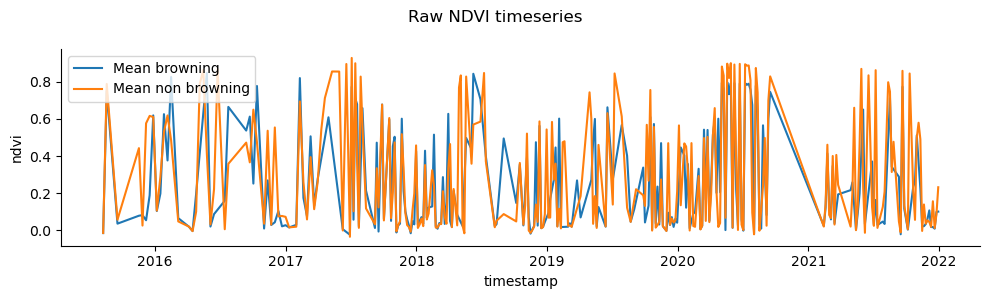

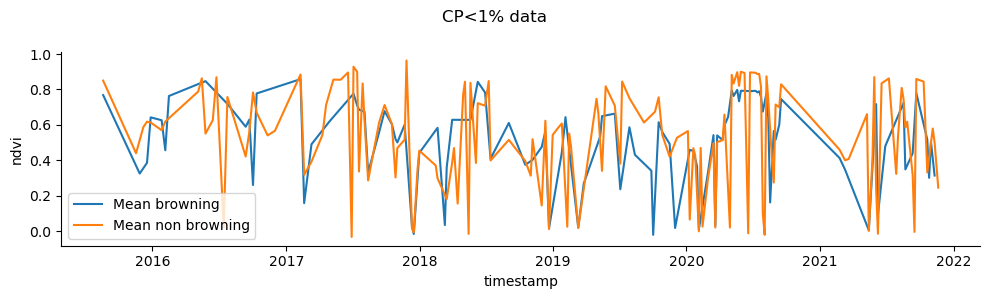

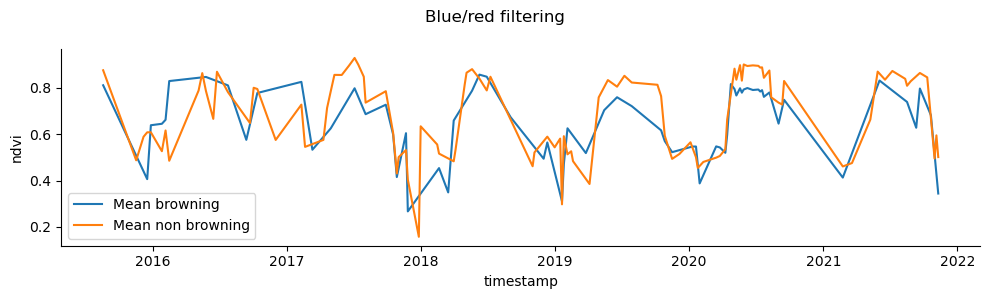

In [64]:
df_brown = df_NDVI_brown.groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='Mean browning')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI.groupby('timestamp').mean().reset_index(), label='Mean non browning')
sns.despine(top=True, right=True)
plt.tight_layout()


fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('CP<1% data')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[df_NDVI_brown.cp<1].groupby('timestamp').mean().reset_index(), label='Mean browning')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[df_NDVI.cp<1].groupby('timestamp').mean().reset_index(), label='Mean non browning')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Blue/red filtering')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.b2<0.05) & (df_NDVI_brown.b8>0.15)].groupby('timestamp').mean().reset_index(), label='Mean browning')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.b2<0.05) & (df_NDVI.b8>0.15)].groupby('timestamp').mean().reset_index(), label='Mean non browning')
sns.despine(top=True, right=True)
plt.tight_layout()

# Compare browning vs non-browning with mean and std plots

In [10]:
monthly_means_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.1)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.1)].groupby('month').std().ndvi.reset_index()
summer_mean_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.1)].ndvi.mean()
summer_std_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.1)].ndvi.std()

monthly_means_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.1)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.1)].groupby('month').std().ndvi.reset_index()
summer_mean_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.1)].ndvi.mean()
summer_std_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.1)].ndvi.std()

NameError: name 'df_NDVI' is not defined

In [17]:
monthly_means_2017.month

0    5
1    6
2    7
3    8
Name: month, dtype: int64

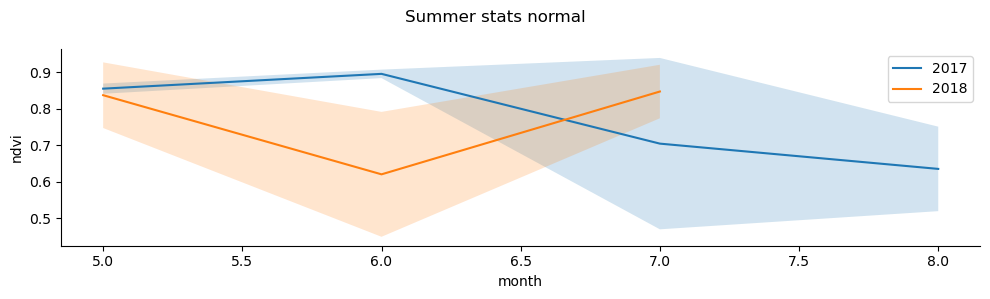

In [23]:
# Plot monthly/summer mean normal 

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal')
sns.lineplot(ax=axs, x='month', y='ndvi', data=monthly_means_2017, label='2017')
axs.fill_between(x=monthly_means_2017.month, y1=monthly_means_2017.ndvi-monthly_stds_2017.ndvi, y2=monthly_means_2017.ndvi+monthly_stds_2017.ndvi, alpha=0.2)
sns.lineplot(ax=axs, x='month', y='ndvi', data=monthly_means_2018, label='2018')
axs.fill_between(x=monthly_means_2018.month, y1=monthly_means_2018.ndvi-monthly_stds_2018.ndvi, y2=monthly_means_2018.ndvi+monthly_stds_2018.ndvi, alpha=0.2)
sns.despine(top=True, right=True)
plt.tight_layout()

In [32]:
df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2017)]

,timestamp,ndvi,cp,b2,b8,coords,year,day,month,wkt
4680,2017-07-19,0.6937,0.0,0.0745,0.3933,POINT (6.49336 46.66657),2017,200,7,POINT (6.4933622249999994 46.6665730769230791)
4681,2017-07-19,0.6694,0.0,0.0752,0.3800,POINT (6.49363 46.66657),2017,200,7,POINT (6.4936266749999998 46.6665730769230791)
4682,2017-07-19,0.6375,1.0,0.0775,0.3752,POINT (6.49389 46.66657),2017,200,7,POINT (6.4938911249999993 46.6665730769230791)
4683,2017-07-19,0.6286,1.0,0.0682,0.3581,POINT (6.49416 46.66657),2017,200,7,POINT (6.4941555749999997 46.6665730769230791)
4684,2017-07-19,0.6605,1.0,0.0650,0.3571,POINT (6.49442 46.66657),2017,200,7,POINT (6.4944200249999993 46.6665730769230791)
...,...,...,...,...,...,...,...,...,...,...
57455,2017-06-09,0.0043,100.0,1.0870,0.9559,POINT (6.49733 46.66329),2017,160,6,POINT (6.4973289749999994 46.6632869230769245)
57456,2017-06-09,0.0007,100.0,1.0855,0.9514,POINT (6.49759 46.66329),2017,160,6,POINT (6.4975934249999998 46.6632869230769245)
57457,2017-06-09,-0.0009,100.0,1.0864,0.9566,POINT (6.49786 46.66329),2017,160,6,POINT (6.4978578749999993 46.6632869230769245)
57458,2017-06-09,0.0001,100.0,1.0900,0.9606,POINT (6.49812 46.66329),2017,160,6,POINT (6.4981223249999998 46.6632869230769245)


NameError: name 'summer_mean_2017' is not defined

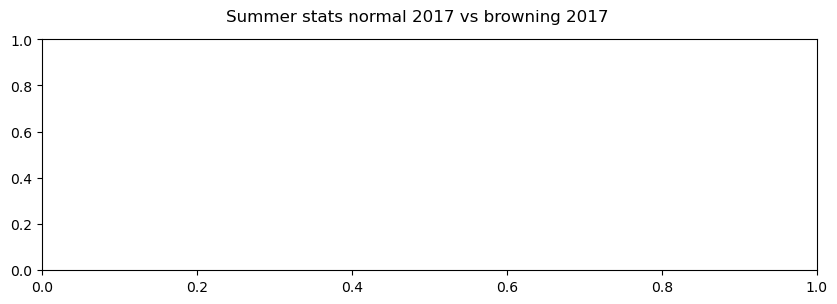

In [9]:
# Plot summer mean +/- std of non browning 2017 and compare to browning

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal 2017 vs browning 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2017)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal 2017 vs browning 2018')
axs.axhline(summer_mean_2017, linestyle='--', color='red')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2018)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal 2017 vs browning 2018 (CP filtered)')
axs.axhline(summer_mean_2017, linestyle='--', color='red')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2018) & (df_NDVI_brown.cp<10)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal 2017 vs browning 2018 (band filtered)')
axs.axhline(summer_mean_2017, linestyle='--', color='red')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2018) & (df_NDVI_brown.b2<0.1) & (df_NDVI_brown.cp>1)])
axs.set_ylim(0,1)

(0.0, 1.0)

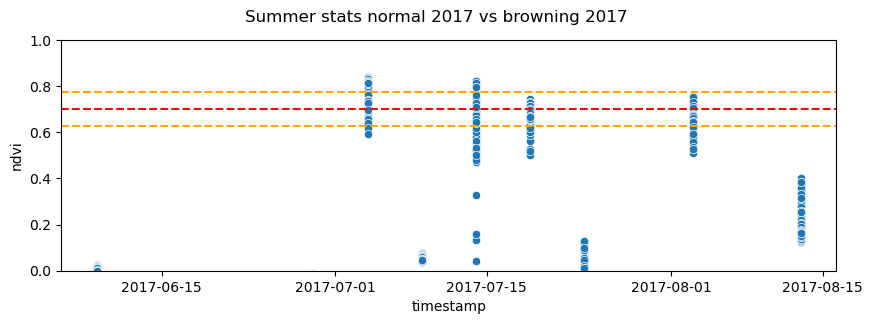

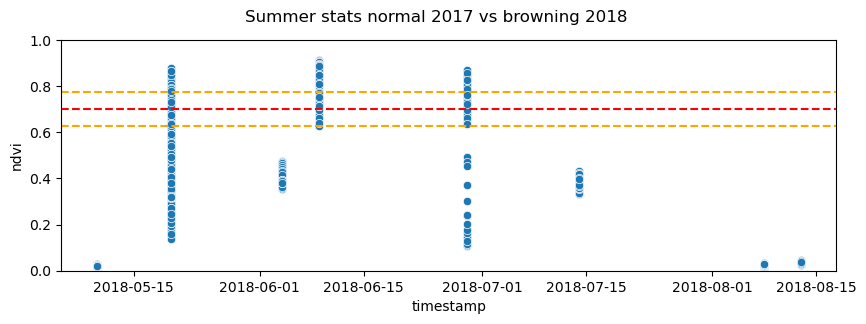

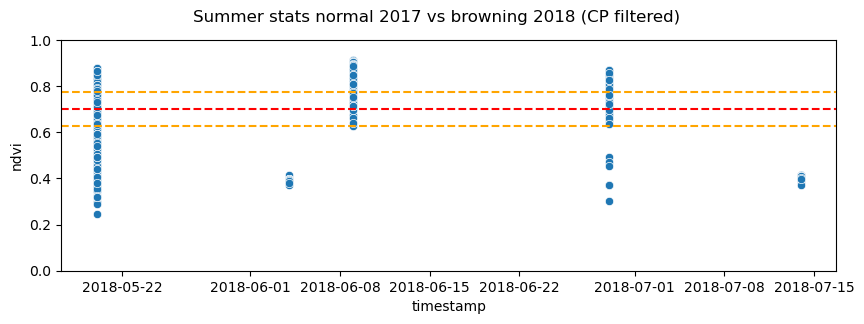

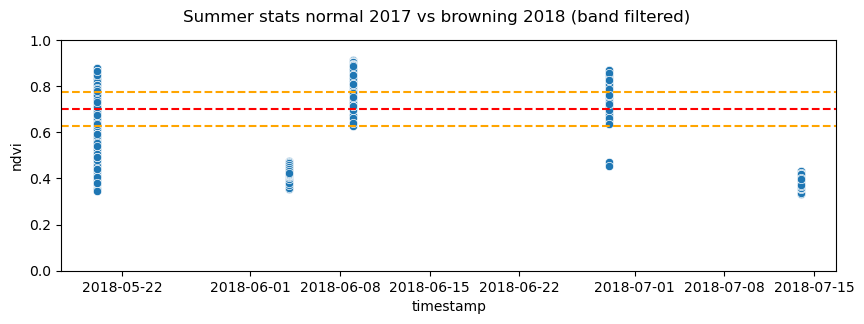

In [43]:
# Plot summer mean +/- std of browning 2017 and compare to browning 2018


summer_mean_2017 = df_NDVI_brown[(df_NDVI_brown.year==2017) & (df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.cp<10) & (df_NDVI_brown.b2<0.2) & (df_NDVI_brown.b8>0.1)].ndvi.mean()
summer_std_2017 = df_NDVI_brown[(df_NDVI_brown.year==2017) & (df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.cp<10) & (df_NDVI_brown.b2<0.2) & (df_NDVI_brown.b8>0.1)].ndvi.std()

summer_mean_2018 = df_NDVI_brown[(df_NDVI_brown.year==2018) & (df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.cp<10) & (df_NDVI_brown.b2<0.2) & (df_NDVI_brown.b8>0.1)].ndvi.mean()
summer_std_2018 = df_NDVI_brown[(df_NDVI_brown.year==2018) & (df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.cp<10) & (df_NDVI_brown.b2<0.2) & (df_NDVI_brown.b8>0.1)].ndvi.std()


fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal 2017 vs browning 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2017)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal 2017 vs browning 2018')
axs.axhline(summer_mean_2017, linestyle='--', color='red')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2018)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal 2017 vs browning 2018 (CP filtered)')
axs.axhline(summer_mean_2017, linestyle='--', color='red')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2018) & (df_NDVI_brown.cp<10)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats normal 2017 vs browning 2018 (band filtered)')
axs.axhline(summer_mean_2017, linestyle='--', color='red')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.month.isin([5,6,7,8])) & (df_NDVI_brown.year==2018) & (df_NDVI_brown.b2<0.2) & (df_NDVI_brown.b8>0.1)])
axs.set_ylim(0,1)

# Anomaly analysis

In [29]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [6]:
#df_filtered = df_NDVI_brown[(df_NDVI_brown.b2<0.1) & (df_NDVI_brown.b8>0.15) & (df_NDVI_brown.year==2017)]
df_filtered = df_NDVI_brown[(df_NDVI_brown.cp<10) & (df_NDVI_brown.year!=2018)]

# Calculate mean/std of each month of year 2017 and use those to normalise
#means = df_filtered.groupby(['year', 'month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})
means = df_filtered.groupby(['month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})
means = means.drop(0, axis=0)

/tmp/ipykernel_1258957/2754990384.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = df_filtered.groupby(['month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})


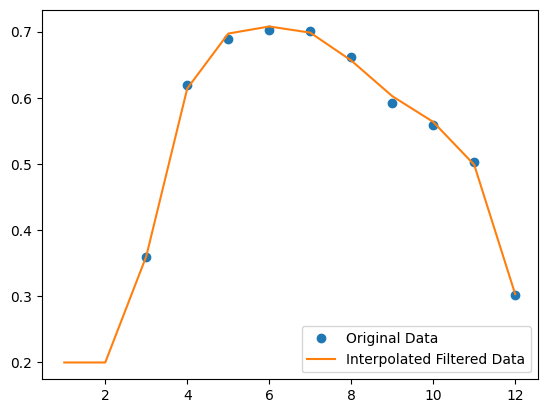

In [7]:


# For all years means: drop month 2 
means = means.drop(1, axis=0)

# Interpolate months between (SG filter)
y_smooth = savgol_filter(means["mean"].tolist(), 5, 3, deriv=0, delta=1.0)


# Interpolate filtered data
interp_func = interp1d(means["month"].tolist(), y_smooth, kind='cubic', fill_value="extrapolate")
x_interp = np.arange(1,13,1)
y_interp = interp_func(x_interp)
y_interp = np.clip(y_interp, 0.2, 1)

# Plot the original and interpolated filtered data
import matplotlib.pyplot as plt
plt.plot(means["month"].tolist(), means["mean"].tolist(), 'o', label='Original Data')
plt.plot(x_interp, y_interp, '-', label='Interpolated Filtered Data')
plt.legend()
plt.show()

means_int = pd.DataFrame()
means_int["month"] = np.arange(1,13,1)
means_int["mean"] = y_interp

In [8]:
# For missing monthly stds, fill in with mean
stds = df_filtered.groupby(['month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})
"""
stds = pd.concat([pd.DataFrame({'year':[2017], 'month':[1], 'std':[stds["std"].mean()]}), stds], ignore_index=True)
stds = pd.concat([pd.DataFrame({'year':[2017], 'month':[5], 'std':[stds["std"].mean()]}), stds], ignore_index=True)
stds = pd.concat([pd.DataFrame({'year':[2017], 'month':[6], 'std':[stds["std"].mean()]}), stds], ignore_index=True)
"""

/tmp/ipykernel_1258957/574366800.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = df_filtered.groupby(['month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})


'\nstds = pd.concat([pd.DataFrame({\'year\':[2017], \'month\':[1], \'std\':[stds["std"].mean()]}), stds], ignore_index=True)\nstds = pd.concat([pd.DataFrame({\'year\':[2017], \'month\':[5], \'std\':[stds["std"].mean()]}), stds], ignore_index=True)\nstds = pd.concat([pd.DataFrame({\'year\':[2017], \'month\':[6], \'std\':[stds["std"].mean()]}), stds], ignore_index=True)\n'

In [9]:
# Merge on timestamp to add means and stds
df_NDVI_brown = df_NDVI_brown.merge(means_int, how='left', on=['month'])
df_NDVI_brown = df_NDVI_brown.merge(stds, how='left', on=['month'])
# Compute z-score
df_NDVI_brown['zscore'] = (df_NDVI_brown['ndvi']-df_NDVI_brown['mean'])/df_NDVI_brown['std'] 
df_NDVI_brown = df_NDVI_brown.rename(columns={'year_x':'year'})

In [10]:
# Find pixel that has most anomalies IN SUMMER
df_NDVI_brown[df_NDVI_brown.month.isin([6,7,8,9])].groupby('wkt').sum().zscore.reset_index().sort_values('zscore').head(10)

/tmp/ipykernel_1258957/242697870.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_NDVI_brown[df_NDVI_brown.month.isin([6,7,8,9])].groupby('wkt').sum().zscore.reset_index().sort_values('zscore').head(10)


,wkt,zscore
26,POINT (6.49638 46.664625),-166.606010
20,POINT (6.4961400000000005 46.664625),-164.252645
27,POINT (6.49638 46.664875),-163.698921
14,POINT (6.495900000000001 46.664625),-160.142854
28,POINT (6.49638 46.665125),-160.041013
21,POINT (6.4961400000000005 46.664875),-157.188743
7,POINT (6.49566 46.664375),-156.928035
13,POINT (6.495900000000001 46.664375),-155.249570
19,POINT (6.4961400000000005 46.664375),-152.361581
8,POINT (6.49566 46.664625),-151.767704


In [30]:
# VAUD

# Compare difference monthly mean all yrs and 2018

"""
# 2017
df_filtered = df_NDVI_brown[(df_NDVI_brown.cp<10) & (df_NDVI_brown.year==2017)]
means = df_filtered.groupby(['year', 'month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})
means = means.drop(0, axis=0)

y_smooth = savgol_filter(means["mean"].tolist(), 5, 3, deriv=0, delta=1.0)
interp_func = interp1d(means["month"].tolist(), y_smooth, kind='cubic', fill_value="extrapolate")
x_interp = np.arange(1,13,1)
y_interp = interp_func(x_interp)
y_interp = np.clip(y_interp, 0.2, 1)

means = pd.DataFrame()
means["month"] = np.arange(1,13,1)
means["mean"] = y_interp

stds = df_filtered.groupby(['year', 'month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})
stds = pd.concat([pd.DataFrame({'year':[2017], 'month':[1], 'std':[stds["std"].mean()]}), stds], ignore_index=True)
stds = pd.concat([pd.DataFrame({'year':[2017], 'month':[5], 'std':[stds["std"].mean()]}), stds], ignore_index=True)
stds = pd.concat([pd.DataFrame({'year':[2017], 'month':[6], 'std':[stds["std"].mean()]}), stds], ignore_index=True)
 
means = means.merge(stds[["month", "std"]], on="month", how="left")
"""
# All years
df_filtered = df_NDVI_brown[(df_NDVI_brown.cp<10) & (df_NDVI_brown.year!=2017)]
means = df_filtered.groupby(['month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})
# For all years means: drop month 2 
means = means.drop(1, axis=0)

y_smooth = savgol_filter(means["mean"].tolist(), 5, 3, deriv=0, delta=1.0)
interp_func = interp1d(means["month"].tolist(), y_smooth, kind='cubic', fill_value="extrapolate")
x_interp = np.arange(1,13,1)
y_interp = interp_func(x_interp)
y_interp = np.clip(y_interp, 0.2, 1)

means = pd.DataFrame()
means["month"] = np.arange(1,13,1)
means["mean"] = y_interp

stds = df_filtered.groupby(['month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})
means = means.merge(stds[["month", "std"]], on="month", how="left")

/tmp/ipykernel_2357785/2804506993.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = df_filtered.groupby(['month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})
/tmp/ipykernel_2357785/2804506993.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds = df_filtered.groupby(['month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})


In [31]:
# 2018
df_filtered = df_NDVI_brown[(df_NDVI_brown.cp<10) & (df_NDVI_brown.year==2018)]
means_18 = df_filtered.groupby(['month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})

y_smooth = savgol_filter(means_18["mean"].tolist(), 5, 3, deriv=0, delta=1.0)
interp_func = interp1d(means_18["month"].tolist(), y_smooth, kind='cubic', fill_value="extrapolate")
x_interp = np.arange(1,13,1)
y_interp = interp_func(x_interp)
y_interp = np.clip(y_interp, 0.2, 1)

means_int18 = pd.DataFrame()
means_int18["month"] = np.arange(1,13,1)
means_int18["mean"] = y_interp

stds_18 = df_filtered.groupby(['year', 'month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})
stds_18 = pd.concat([pd.DataFrame({'year':[2018], 'month':[1], 'std':[stds_18["std"].mean()]}), stds_18], ignore_index=True)
stds_18 = pd.concat([pd.DataFrame({'year':[2018], 'month':[4], 'std':[stds_18["std"].mean()]}), stds_18], ignore_index=True)
stds_18 = pd.concat([pd.DataFrame({'year':[2018], 'month':[6], 'std':[stds_18["std"].mean()]}), stds_18], ignore_index=True)
stds_18 = pd.concat([pd.DataFrame({'year':[2018], 'month':[8], 'std':[stds_18["std"].mean()]}), stds_18], ignore_index=True)
 
means_int18 = means_int18.merge(stds_18[["month", "std"]], on="month", how="left")

/tmp/ipykernel_2357785/2507124020.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_18 = df_filtered.groupby(['month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})
/tmp/ipykernel_2357785/2507124020.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stds_18 = df_filtered.groupby(['year', 'month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})


In [205]:
# SCHAFFHAUSEN

# Compare difference monthly mean 2017 and 2018

# 2017
df_filtered = df_NDVI_brown[(df_NDVI_brown.cp<10) & (df_NDVI_brown.year==2017)]
means = df_filtered.groupby(['year', 'month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})
means = means.drop([0,9], axis=0)

y_smooth = savgol_filter(means["mean"].tolist(), 5, 3, deriv=0, delta=1.0)
interp_func = interp1d(means["month"].tolist(), y_smooth, kind='cubic', fill_value="extrapolate")
x_interp = np.arange(1,13,1)
y_interp = interp_func(x_interp)
y_interp = np.clip(y_interp, 0.2, 1)

means = pd.DataFrame()
means["month"] = np.arange(1,13,1)
means["mean"] = y_interp

stds = df_filtered.groupby(['year', 'month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})
stds = pd.concat([pd.DataFrame({'year':[2017], 'month':[2], 'std':[stds["std"].mean()]}), stds], ignore_index=True)
 
means = means.merge(stds[["month", "std"]], on="month", how="left")


# 2018
df_filtered = df_NDVI_brown[(df_NDVI_brown.cp<10) & (df_NDVI_brown.year==2018)]
means_18 = df_filtered.groupby(['year', 'month']).mean().ndvi.reset_index().rename(columns={'ndvi':'mean'})


means_int18 = pd.DataFrame()
means_int18["month"] = np.arange(1,13,1)
means_int18["mean"] = means_18["mean"]

stds_18 = df_filtered.groupby(['year', 'month']).std().ndvi.reset_index().rename(columns={'ndvi':'std'})
stds_18 = pd.concat([pd.DataFrame({'year':[2018], 'month':[9], 'std':[stds_18["std"].mean()]}), stds_18], ignore_index=True)
 
means_int18 = means_int18.merge(stds_18[["month", "std"]], on="month", how="left")

In [32]:
df_filtered = df_NDVI_brown[(df_NDVI_brown.cp<10) & (df_NDVI_brown.year==2018)]
#df_filtered = df_filtered.drop(["mean", "year_y", "std", "zscore"], axis=1)
df_filtered = df_filtered.merge(means[["month", "mean"]], on="month", how="left")
df_filtered = df_filtered.merge(stds[["month", "std"]], on="month", how="left")
df_filtered["zscore"] = (df_filtered["ndvi"] - df_filtered["mean"])/df_filtered["std"]

/tmp/ipykernel_2357785/3743129874.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(labels)
/tmp/ipykernel_2357785/3743129874.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  z_mean = df_filtered[(df_filtered.year==2018) & (df_filtered.month.isin([4,5,6,7,8,9]))].groupby('month').mean().zscore.reset_index().rename(columns={'zscore':'mean'})
/tmp/ipykernel_2357785/3743129874.py:42: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  zscores_std = df_filtered[(df_filtered.year==2018) & (df_filtered.month.isin([4,5,6,7,8,9]))].groupby('month').std().zscore.

(-5.0, 0.0)

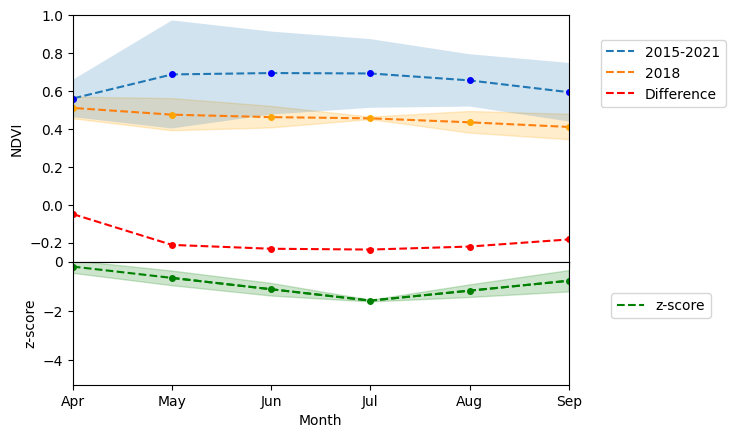

In [39]:
# Anomalyse / zscore

"""
Approach:
- calculate mean --> interp with savgol
- calculate std: fill missing with mean std
"""

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=0)

axs[0].plot(means["month"].tolist(), means["mean"].tolist(), '--', label='2015-2021')
axs[0].plot(means["month"].tolist(), means["mean"].tolist(), 'o',  markersize=4, color='blue', label='_nolegend_')
axs[0].plot(means_int18["month"].tolist(), means_int18["mean"].tolist(), '--', label='2018')
axs[0].plot(means_int18["month"].tolist(), means_int18["mean"].tolist(), 'o', label='_nolegend_', markersize=4, color='orange')
axs[0].fill_between(means_int18["month"].tolist(), (means_int18["mean"]-means_int18["std"]).tolist(), (means_int18["mean"]+means_int18["std"]).tolist(), alpha=0.2, color='orange')
axs[0].fill_between(means["month"].tolist(), (means["mean"]-means["std"]).tolist(), (means["mean"]+means["std"]).tolist(), alpha=0.2)
axs[0].plot(means["month"].tolist(), (means_int18["mean"]-means["mean"]).tolist(), '--', label='Difference', color='red')
axs[0].plot(means["month"].tolist(), (means_int18["mean"]-means["mean"]).tolist(), 'o', label='_nolegend_', color='red', markersize=4)
#axs[0].set_title("Monthly mean of cloud-free NDVI and z-score for 2018")
axs[0].set_ylabel("NDVI")
#axs[0].legend()
axs[0].set_xlim(4,9)
axs[0].set_ylim(-0.3, 1)
labels = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
axs[0].set_xticklabels(labels)
axs[0].legend(loc=7)
axs[0].legend(bbox_to_anchor=(1.05, 0.6))


z_mean = df_filtered[(df_filtered.year==2018) & (df_filtered.month.isin([4,5,6,7,8,9]))].groupby('month').mean().zscore.reset_index().rename(columns={'zscore':'mean'})
z_smooth = savgol_filter(z_mean["mean"].tolist(), 3, 2, deriv=0, delta=1.0)
interp_func = interp1d(z_mean["month"].tolist(), z_smooth, kind='linear', fill_value="extrapolate")
x_interp = np.arange(4,10,1)
y_interp = interp_func(x_interp)
y_interp = np.clip(y_interp, -5, 0)

zsmooth = pd.DataFrame()
zsmooth["month"] = np.arange(4,10,1)
zsmooth["mean"] = y_interp

zscores_std = df_filtered[(df_filtered.year==2018) & (df_filtered.month.isin([4,5,6,7,8,9]))].groupby('month').std().zscore.reset_index().rename(columns={'zscore':'std'})
zscores_std = pd.concat([pd.DataFrame({'month':[6], 'std':[zscores_std["std"].mean()]}), zscores_std], ignore_index=True)
zscores_std = pd.concat([pd.DataFrame({'month':[4], 'std':[zscores_std["std"].mean()]}), zscores_std], ignore_index=True)
zscores_std = pd.concat([pd.DataFrame({'month':[8], 'std':[zscores_std["std"].mean()]}), zscores_std], ignore_index=True)

zsmooth = zsmooth.merge(zscores_std, on="month", how="left")

sns.lineplot(ax=axs[1], data=df_filtered[(df_filtered.year==2018) & (df_filtered.month.isin([4,5,6,7,8,9]))], x='month', y='zscore', color='green', dashes=True, ci=None)
axs[1].plot(zsmooth["month"].tolist(), zsmooth["mean"], 'o', color='green', markersize=4)
axs[1].plot(zsmooth["month"].tolist(), zsmooth["mean"], '--', color='green', label='z-score')
axs[1].fill_between(zsmooth["month"].tolist(), (zsmooth["mean"]-zsmooth["std"]).tolist(), (zsmooth["mean"]+zsmooth["std"]).tolist(), alpha=0.2, color='green')
axs[1].lines[0].set_linestyle("--")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("z-score")
#axs[1].set_xlim(4,9)
axs[1].legend(loc=7)
axs[1].legend(bbox_to_anchor=(1.30, 0.8))
axs[1].set_ylim(-5,0)

(0.0, 1.0)

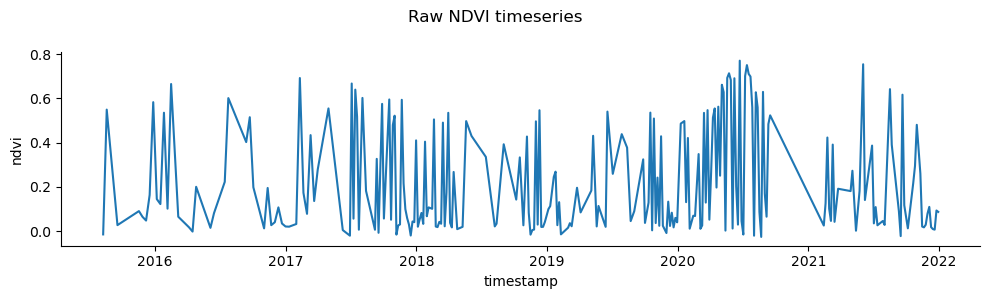

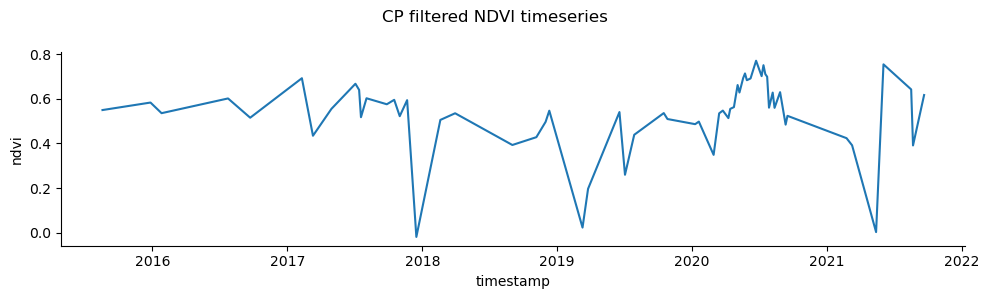

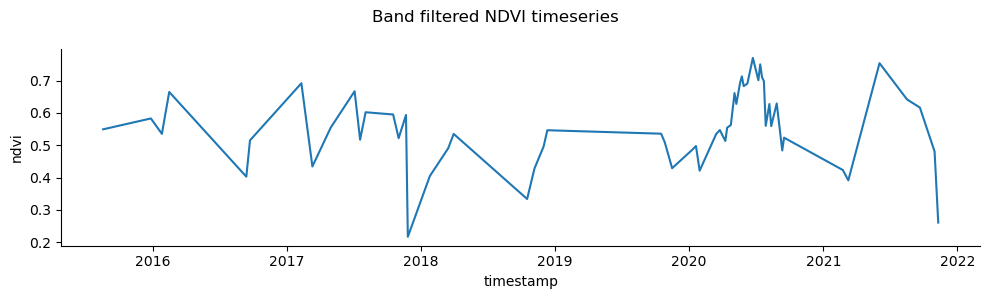

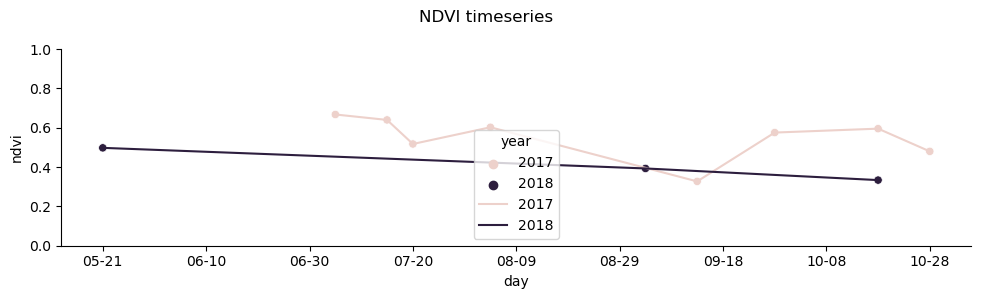

In [175]:
# POINT (6.4912468292682926 46.6689178571428585) POINT (6.4936266749999998 46.6654776923076966)
# POINT (6.4941555749999997 46.6635607692307701

df_pix = df_NDVI_brown[df_NDVI_brown.wkt == 'POINT (6.4963499999999996 46.6647500000000051)']
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix)
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('CP filtered NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix[df_pix.cp<1])
sns.despine(top=True, right=True)
plt.tight_layout()


fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Band filtered NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix[(df_pix.b2<0.1) & (df_pix.b8>0.15)])
sns.despine(top=True, right=True)
plt.tight_layout()

# Compare cloud-free July 2017/18
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI timeseries')
sns.scatterplot(ax=axs, x='day', y='ndvi', data=df_pix[(df_pix.cp<10) & (df_pix.year.isin([2017, 2018])) & (df_pix.month.isin([5,6,7,8,9,10]))], hue='year')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_pix[(df_pix.cp<10) & (df_pix.year.isin([2017, 2018])) & (df_pix.month.isin([5,6,7,8,9,10]))], hue='year')
sns.despine(top=True, right=True)
plt.tight_layout()
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axs.set_ylim(0,1)

# Pixel analysis

NameError: name 'df_pix' is not defined

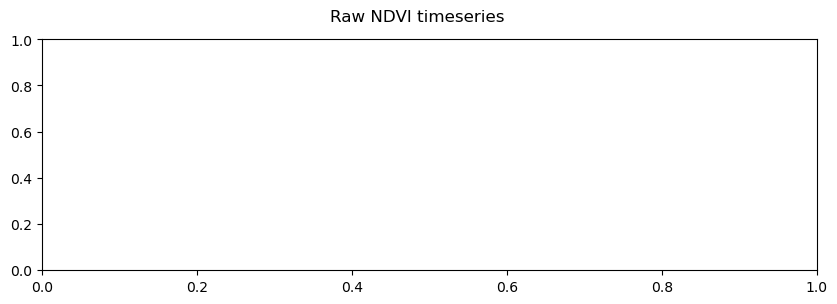

In [ ]:
# BROWNING
# POINT (6.4964759090909094 46.6650974999999946)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.wkt == 'POINT (6.4897073170731714 46.6683835714285706)')], label='raw')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.wkt == 'POINT (6.4897073170731714 46.6683835714285706)') & (df_NDVI_brown.cp<1)], color='red', label='CP filter')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.wkt == 'POINT (6.4897073170731714 46.6683835714285706)') & (df_NDVI_brown.cp<1) & (df_NDVI_brown.year.isin([2017,2018]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.wkt == 'POINT (6.4897073170731714 46.6683835714285706)')], label='raw')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.wkt == 'POINT (6.4897073170731714 46.6683835714285706)') & (df_NDVI_brown.b2<0.05) & (df_NDVI_brown.b8>0.15)], color='red', label='Red/Blue filter')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI_brown[(df_NDVI_brown.wkt == 'POINT (6.4897073170731714 46.6683835714285706)') & (df_NDVI_brown.b2<0.05) & (df_NDVI_brown.b8>0.15) & (df_NDVI_brown.year.isin([2017,2018]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axs.set_ylim(0,1)
plt.tight_layout()

In [21]:
df_NDVI.head(15)

,timestamp,ndvi,cp,b2,b8,coords,year,day,wkt
0,2018-03-11,0.0308,84.0,0.8138,0.8498,POINT (6.43103 46.68211),2018,70,POINT (6.4310312068965523 46.6821071052631567)
1,2018-03-11,0.0292,84.0,0.8189,0.8466,POINT (6.43129 46.68211),2018,70,POINT (6.4312936206896554 46.6821071052631567)
2,2018-03-11,0.0304,85.0,0.8151,0.8483,POINT (6.43156 46.68211),2018,70,POINT (6.4315560344827594 46.6821071052631567)
3,2018-03-11,0.0307,85.0,0.8112,0.8482,POINT (6.43182 46.68211),2018,70,POINT (6.4318184482758625 46.6821071052631567)
4,2018-03-11,0.0299,84.0,0.8103,0.8492,POINT (6.43208 46.68211),2018,70,POINT (6.4320808620689665 46.6821071052631567)
5,2018-03-11,0.0278,83.0,0.8097,0.8462,POINT (6.43234 46.68211),2018,70,POINT (6.4323432758620696 46.6821071052631567)
6,2018-03-11,0.0253,82.0,0.8093,0.8474,POINT (6.43261 46.68211),2018,70,POINT (6.4326056896551727 46.6821071052631567)
7,2018-03-11,0.0292,82.0,0.8065,0.8467,POINT (6.43287 46.68211),2018,70,POINT (6.4328681034482766 46.6821071052631567)
8,2018-03-11,0.0292,81.0,0.8109,0.8444,POINT (6.43313 46.68211),2018,70,POINT (6.4331305172413797 46.6821071052631567)
9,2018-03-11,0.0295,81.0,0.8081,0.8474,POINT (6.43339 46.68211),2018,70,POINT (6.4333929310344828 46.6821071052631567)


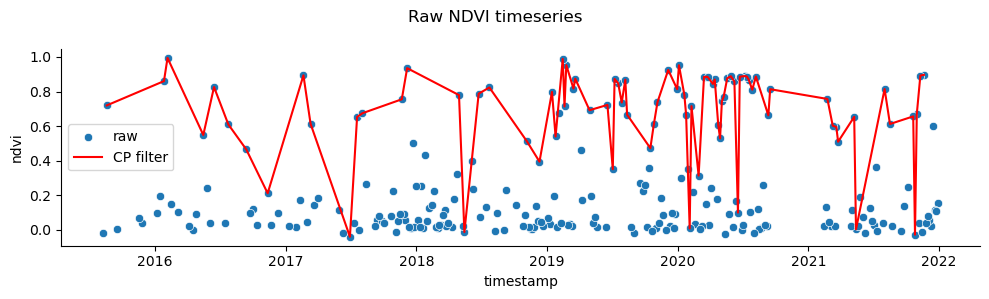

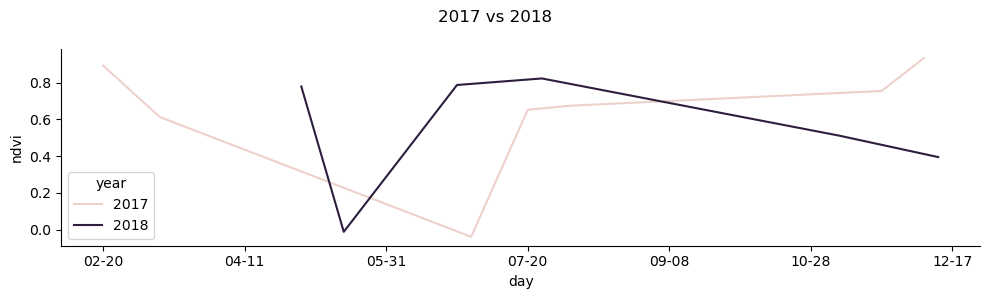

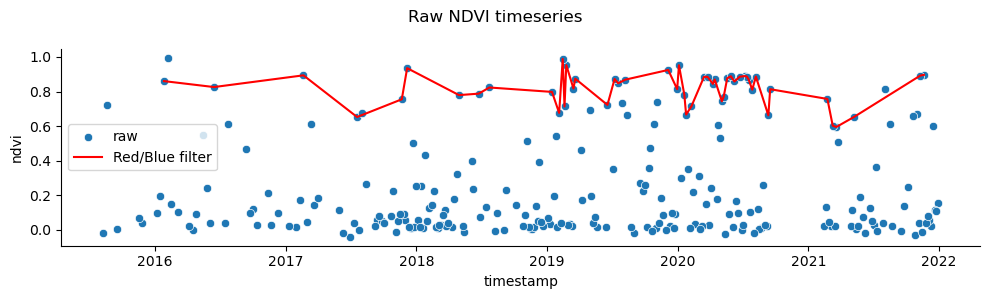

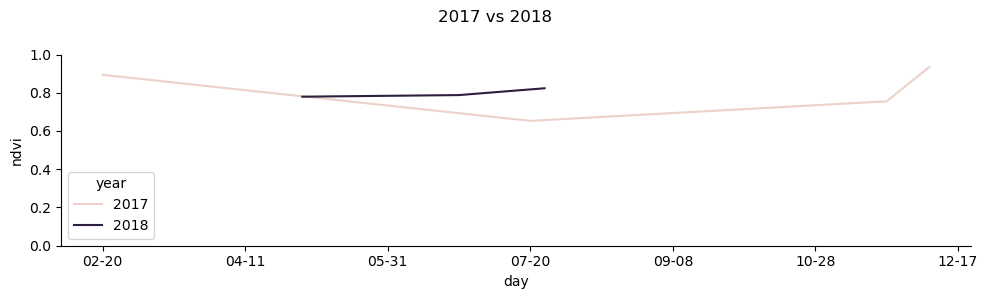

In [22]:
# NON BROWNING

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.wkt == 'POINT (6.4331305172413797 46.6821071052631567)')], label='raw')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.wkt == 'POINT (6.4331305172413797 46.6821071052631567)') & (df_NDVI.cp<10)], color='red', label='CP filter')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.wkt == 'POINT (6.4331305172413797 46.6821071052631567)') & (df_NDVI.cp<10) & (df_NDVI.year.isin([2017,2018]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.wkt == 'POINT (6.4331305172413797 46.6821071052631567)')], label='raw')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.wkt == 'POINT (6.4331305172413797 46.6821071052631567)') & (df_NDVI.b2<0.05) & (df_NDVI.b8>0.15)], color='red', label='Red/Blue filter')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.wkt == 'POINT (6.4331305172413797 46.6821071052631567)') & (df_NDVI.b2<0.05) & (df_NDVI.b8>0.15) & (df_NDVI.year.isin([2017,2018]))], hue='year')
sns.despine(top=True, right=True)
axs.set_ylim(0,1)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

## Compare dropping rates per year

In [9]:
drop_cp = df_NDVI_brown[df_NDVI_brown.cp<1].groupby('year').count().ndvi.reset_index()
drop_band = df_NDVI_brown[(df_NDVI_brown.b2<0.1) & (df_NDVI_brown.b8>0.15)].groupby('year').count().ndvi.reset_index()

<AxesSubplot:xlabel='year', ylabel='ndvi'>

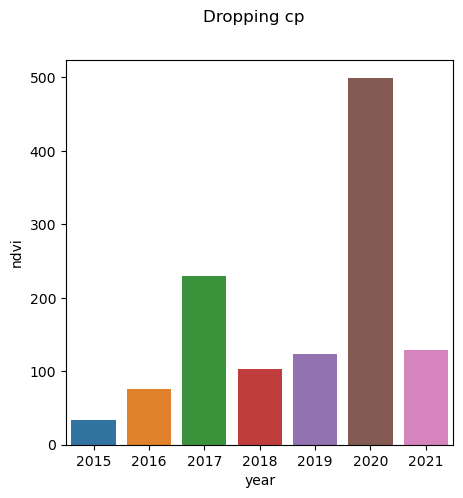

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.suptitle('Dropping cp')
sns.barplot(ax=axs, y=drop_cp.ndvi, x=drop_cp.year, data=drop_band)

## Apply smoothing to a pixel to see if trend conserved

In [6]:
# Select a pixel: lowest ndvi in 2018 (cloud free)

df_cp = df_NDVI_brown[(df_NDVI_brown.cp<1)]
df_sum = df_cp[df_cp.year==2018].groupby('wkt').sum().ndvi.sort_values().reset_index()

In [225]:
df_sum.head(10)

,wkt,ndvi
0,POINT (6.4954499999999999 46.6644500000000022),1.5801
1,POINT (6.4957500000000001 46.6647500000000051),2.0556
2,POINT (6.4957500000000001 46.6650500000000008),2.1321
3,POINT (6.4963499999999996 46.6644500000000022),2.1512
4,POINT (6.4960500000000003 46.6644500000000022),2.1697
5,POINT (6.4960500000000003 46.6647500000000051),2.1873
6,POINT (6.4954499999999999 46.6647500000000051),2.2738
7,POINT (6.4960500000000003 46.6641500000000065),2.3342
8,POINT (6.4957500000000001 46.6653500000000037),2.4647
9,POINT (6.4957500000000001 46.6644500000000022),2.5041


In [6]:
df_pix = df_NDVI_brown[df_NDVI_brown.wkt=='POINT (6.4957500000000001 46.6647500000000051)']
# Drop data before 2018
#df_pix = df_pix[df_pix.timestamp>'2014-12-31']

In [7]:
df_pix

,timestamp,ndvi,cp,b2,b8,coords,year,day,month,wkt
9,2018-03-11,0.0327,96.0,0.9469,1.0030,POINT (6.49575 46.66475),2018,70,3,POINT (6.4957500000000001 46.6647500000000051)
29,2019-01-10,0.0358,73.0,0.3833,0.3729,POINT (6.49575 46.66475),2019,10,1,POINT (6.4957500000000001 46.6647500000000051)
49,2018-12-21,0.0195,100.0,0.9863,1.0352,POINT (6.49575 46.66475),2018,355,12,POINT (6.4957500000000001 46.6647500000000051)
69,2019-06-14,0.0187,66.0,0.8766,0.9888,POINT (6.49575 46.66475),2019,165,6,POINT (6.4957500000000001 46.6647500000000051)
89,2021-06-08,0.1822,0.0,0.9384,0.7941,POINT (6.49575 46.66475),2021,159,6,POINT (6.4957500000000001 46.6647500000000051)
...,...,...,...,...,...,...,...,...,...,...
4769,2017-01-10,0.0149,100.0,1.1315,1.1255,POINT (6.49575 46.66475),2017,10,1,POINT (6.4957500000000001 46.6647500000000051)
4789,2018-08-08,0.0242,100.0,1.0475,0.9170,POINT (6.49575 46.66475),2018,220,8,POINT (6.4957500000000001 46.6647500000000051)
4809,2018-05-10,0.0241,100.0,1.0911,1.1331,POINT (6.49575 46.66475),2018,130,5,POINT (6.4957500000000001 46.6647500000000051)
4829,2017-11-16,0.0357,100.0,0.6261,0.6725,POINT (6.49575 46.66475),2017,320,11,POINT (6.4957500000000001 46.6647500000000051)


<AxesSubplot:xlabel='cp', ylabel='Count'>

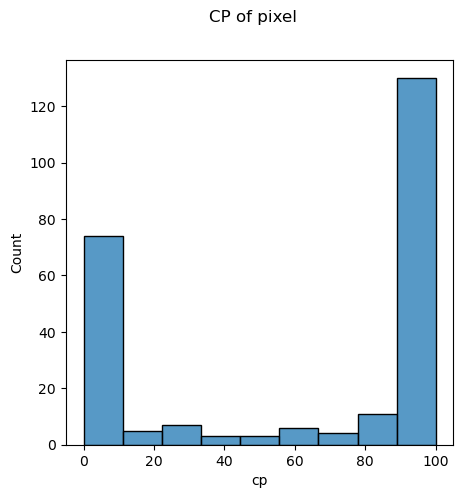

In [241]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.suptitle('CP of pixel')
sns.histplot(ax=axs, x=df_pix.cp, stat='count')

<AxesSubplot:xlabel='year', ylabel='timestamp'>

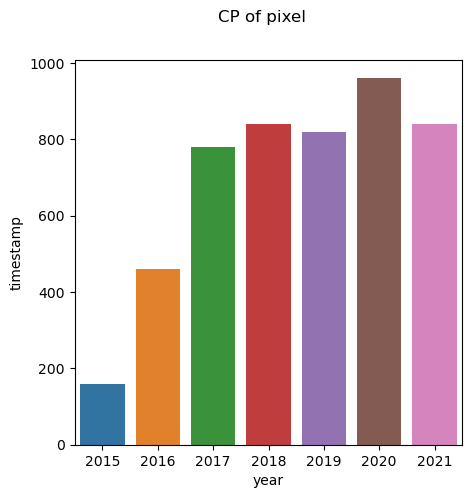

In [264]:
# Measurements per year
count_yr = df_NDVI_brown.groupby('year').count().timestamp.reset_index()

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.suptitle('CP of pixel')
sns.barplot(ax=axs, y=count_yr.timestamp, x=count_yr.year)

'\nfig, axs = plt.subplots(1, 1, figsize=(10, 3))\nplt.suptitle(\'Interp\')\nsns.scatterplot(ax=axs, x=df_cleaned["ts"], y=df_cleaned["ndvi"], label=\'original\')\nsns.scatterplot(ax=axs, x=df_cleaned["ts"], y=df_cleaned["interp"], label=\'interp\')\nsns.despine(top=True, right=True)\naxs.set_ylim(0,1)\nplt.tight_layout()\nplt.legend(loc=\'upper right\')\n\n\ndf_cleaned["year"] = df_cleaned["ts"].apply(lambda x: x.year)\ndf_cleaned["day"] = df_cleaned["ts"].apply(lambda x: x.dayofyear)\n\nfig, axs = plt.subplots(1, 1, figsize=(10, 3))\nplt.suptitle(\'Interpolated/Extrapolated NDVI pixel timeseries\', fontsize=14)\nsns.lineplot(ax=axs, x=\'day\', y=\'interp\', data=df_cleaned, hue=\'year\', palette="Set2")\nsns.despine(top=True, right=True)\naxs.set_ylim(0,1)\nplt.tight_layout()\naxs.set_xlabel(\'Day of year\', fontsize=14)\naxs.set_ylabel(\'NDVI\', fontsize=14)\nplt.xticks(fontsize=13)\nplt.yticks(fontsize=13)\nplt.legend(loc=\'upper right\', bbox_to_anchor=(1.1, 0.9), fontsize=12)\n'

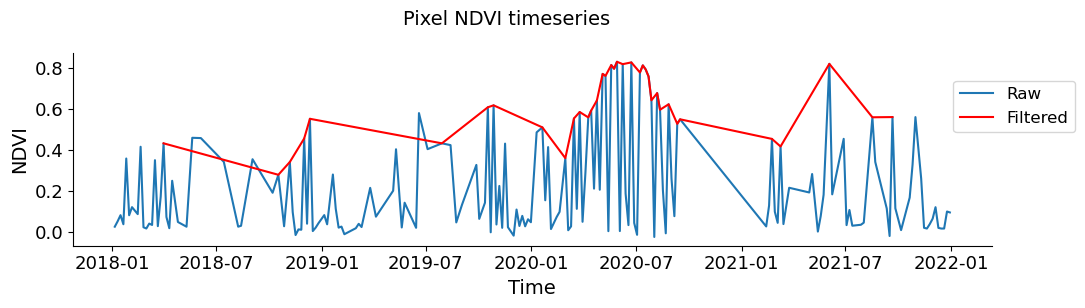

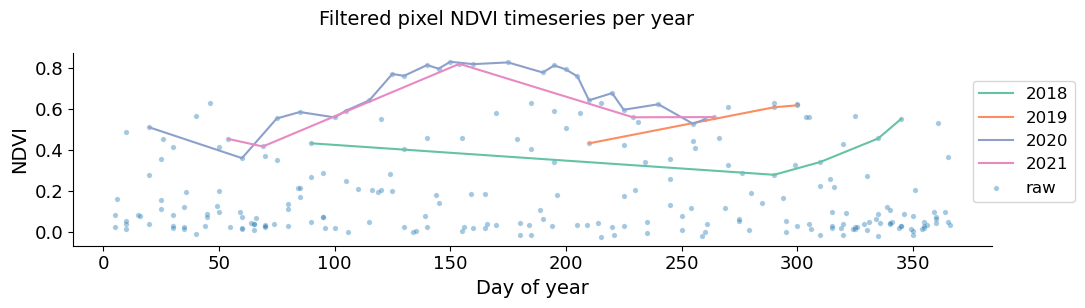

In [15]:
# SMOOTHING
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from scipy import signal


## Step 1.1: drop if B2>5% and B8<15%
#df_pix_clean = df_pix[(df_pix.b2<0.15) & (df_pix.b8>0.10)]
df_pix_clean = df_pix[(df_pix.b2<0.1) & (df_pix.cp<0.01)] #
#df_pix_clean = df_pix[(df_pix.cp<1)]
df_pix_clean = df_pix_clean[(df_pix_clean.year>2017)]


"""
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix) 
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Band filtered pixel timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix_clean, label='Blue/red filter')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_pix, label='raw') #, alpha=0.5)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.legend(loc='upper right')
"""

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Pixel NDVI timeseries',fontsize=14)
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix[df_pix.year>2017], label='Raw')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix_clean, label='Filtered', color='red')
#sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_pix, label='raw') #, alpha=0.5)
sns.despine(top=True, right=True)
plt.tight_layout()
axs.set_xlabel('Time', fontsize=14)
axs.set_ylabel('NDVI', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9), fontsize=12)


fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Filtered pixel NDVI timeseries per year', fontsize=14)
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_pix_clean, hue='year', palette="Set2")
sns.scatterplot(ax=axs, x='day', y='ndvi', data=df_pix, label='raw', alpha=0.4, s=15)
sns.despine(top=True, right=True)
plt.tight_layout()
axs.set_xlabel('Day of year', fontsize=14)
axs.set_ylabel('NDVI', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9), fontsize=12)


# Get a number for each day between 2016 and 2021
date_range = pd.date_range(start='2018-01-01', end='2021-12-31', freq='D')
day_nb = np.arange(1, len(date_range)+1, 1)
day_nb_data = [day_nb[i] for i, d in enumerate(date_range) if d in df_pix_clean.timestamp.tolist()]
df_cleaned = pd.DataFrame()
df_cleaned['ts'] = date_range
df_cleaned['day_nb'] = day_nb
df_cleaned = df_cleaned.merge(df_pix_clean[["timestamp", "ndvi"]], how='left', left_on='ts', right_on="timestamp")

"""
## Step 2: Apply LOESS smoothing
smooth = lowess(df_cleaned.ndvi.dropna().tolist(), day_nb_data, frac=0.01)
#df_pix_clean["smooth"] = smooth[:, 1]

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Smoothed')
sns.lineplot(ax=axs, x=day_nb_data, y= smooth[:, 1], label='LOESS')
sns.lineplot(ax=axs, x=day_nb_data, y=df_cleaned.ndvi.dropna().tolist(), label='original')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Smoothed')
sns.lineplot(ax=axs, x='day', y='smooth', data=df_pix_clean, hue='year', palette="Set2")
sns.despine(top=True, right=True)
plt.tight_layout()
"""

## Step 3: Apply interpolation to get a values for each day
#f = interp1d(day_nb_data, df_cleaned["ndvi"].dropna().tolist(), kind='quadratic', bounds_error = False)
#df_cleaned["interp"] = f(day_nb)

f = interp1d(day_nb_data, df_cleaned["ndvi"].dropna().tolist(), kind='linear', bounds_error = False, fill_value='extrapolate')
y_interp = f(day_nb)
y_interp = np.clip(y_interp, 0, 1)
df_cleaned["interp"] = y_interp


"""
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Interp')
sns.scatterplot(ax=axs, x=df_cleaned["ts"], y=df_cleaned["ndvi"], label='original')
sns.scatterplot(ax=axs, x=df_cleaned["ts"], y=df_cleaned["interp"], label='interp')
sns.despine(top=True, right=True)
axs.set_ylim(0,1)
plt.tight_layout()
plt.legend(loc='upper right')


df_cleaned["year"] = df_cleaned["ts"].apply(lambda x: x.year)
df_cleaned["day"] = df_cleaned["ts"].apply(lambda x: x.dayofyear)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Interpolated/Extrapolated NDVI pixel timeseries', fontsize=14)
sns.lineplot(ax=axs, x='day', y='interp', data=df_cleaned, hue='year', palette="Set2")
sns.despine(top=True, right=True)
axs.set_ylim(0,1)
plt.tight_layout()
axs.set_xlabel('Day of year', fontsize=14)
axs.set_ylabel('NDVI', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9), fontsize=12)
"""

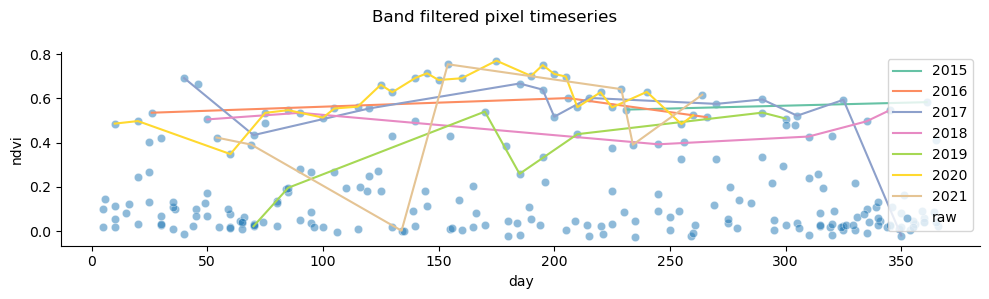

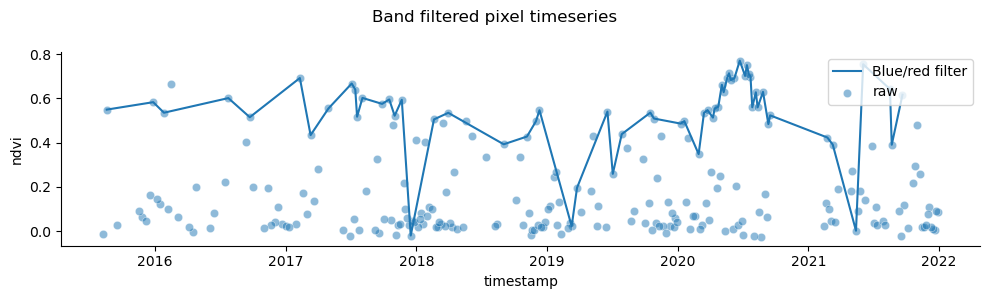

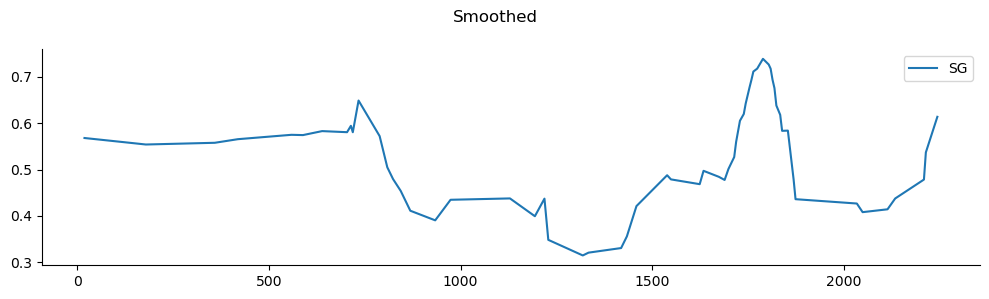

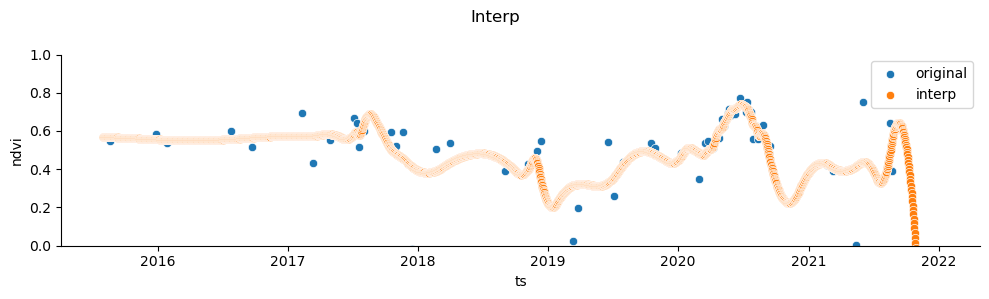

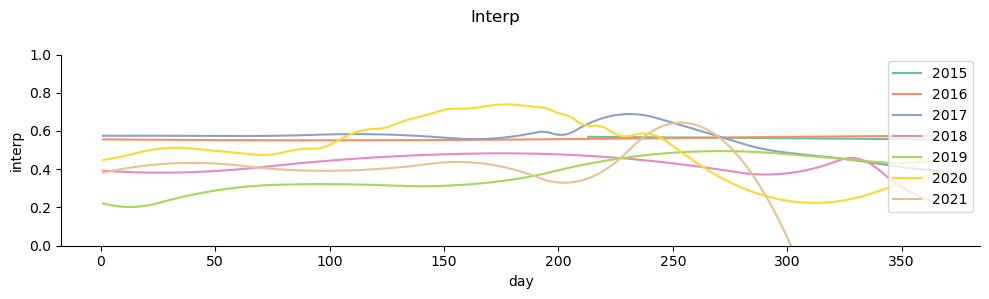

In [180]:
# SMOOTHING
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from scipy import signal


## Step 1.1: drop if B2>5% and B8<15%
#df_pix_clean = df_pix[(df_pix.b2<0.15) & (df_pix.b8>0.10)]
df_pix_clean = df_pix[df_pix.cp<1]

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Band filtered pixel timeseries')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_pix_clean, hue='year', palette="Set2")
sns.scatterplot(ax=axs, x='day', y='ndvi', data=df_pix, label='raw', alpha=0.5)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.legend(loc='upper right')

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Band filtered pixel timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix_clean, label='Blue/red filter')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_pix, label='raw', alpha=0.5)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.legend(loc='upper right')


# Get a number for each day between 2016 and 2021
date_range = pd.date_range(start='2015-08-01', end='2021-12-31', freq='D')
day_nb = np.arange(1, len(date_range)+1, 1)
day_nb_data = [day_nb[i] for i, d in enumerate(date_range) if d in df_pix_clean.timestamp.tolist()]
df_cleaned = pd.DataFrame()
df_cleaned['ts'] = date_range
df_cleaned['day_nb'] = day_nb
df_cleaned = df_cleaned.merge(df_pix_clean[["timestamp", "ndvi"]], how='left', left_on='ts', right_on="timestamp")


## Step 2: Apply SG smoothing

ndvi_smooth = signal.savgol_filter(df_cleaned["ndvi"].dropna().tolist(), window_length=11, polyorder=3, mode="interp")
#df_cleaned["smooth"] = ndvi_smooth

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Smoothed')
sns.lineplot(ax=axs, x=day_nb_data, y=ndvi_smooth,label='SG')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.legend(loc='upper right')


## Step 3: Apply interpolation to get a values for each day
#f = interp1d(day_nb_data, df_cleaned["ndvi"].dropna().tolist(), kind='quadratic', bounds_error = False)
#df_cleaned["interp"] = f(day_nb)

f = interp1d(day_nb_data, ndvi_smooth, kind='quadratic', bounds_error = False, fill_value='extrapolate')
df_cleaned["interp"] = f(day_nb)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Interp')
sns.scatterplot(ax=axs, x=df_cleaned["ts"], y=df_cleaned["ndvi"], label='original')
sns.scatterplot(ax=axs, x=df_cleaned["ts"], y=df_cleaned["interp"], label='interp')
sns.despine(top=True, right=True)
axs.set_ylim(0,1)
plt.tight_layout()
plt.legend(loc='upper right')

df_cleaned["year"] = df_cleaned["ts"].apply(lambda x: x.year)
df_cleaned["day"] = df_cleaned["ts"].apply(lambda x: x.dayofyear)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Interp')
sns.lineplot(ax=axs, x='day', y='interp', data=df_cleaned, hue='year', palette="Set2")
sns.despine(top=True, right=True)
axs.set_ylim(0,1)
plt.tight_layout()
plt.legend(loc='upper right')

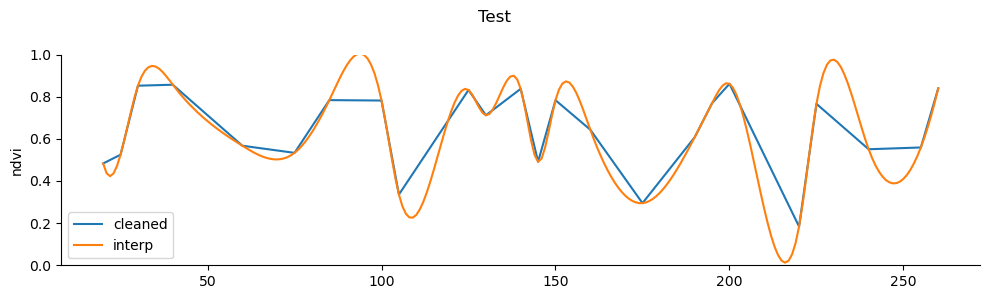

In [365]:
## Step 3: Apply interpolation to get a values for each day
date_range = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
day_nb = np.arange(1, len(date_range)+1, 1)
day_nb_data = [day_nb[i] for i, d in enumerate(date_range) if d in df_pix_clean.timestamp.tolist()]

f = interp1d(day_nb_data, df_pix_clean[df_pix_clean.year==2020]["ndvi"] , kind='cubic', bounds_error = False)
ynew = f(day_nb)

#smooth = lowess(df_pix_clean[df_pix_clean.year==2018]["ndvi"], day_nb_data, frac=0.1)

#ndvi_smooth = signal.savgol_filter(df_pix_clean[df_pix_clean.year==2018]["ndvi"], window_length=7, polyorder=5, mode="interp")

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Test')
sns.lineplot(ax=axs, x=day_nb_data, y=df_pix_clean[df_pix_clean.year==2020]["ndvi"], label='cleaned')
#sns.lineplot(ax=axs, x=day_nb_data, y=ndvi_smooth, label='SG')
#sns.lineplot(ax=axs, x=day_nb_data, y=smooth[:,1], label='Loess')
sns.lineplot(ax=axs, x=day_nb, y=ynew, label='interp')
sns.despine(top=True, right=True)
axs.set_ylim(0,1)
plt.tight_layout()

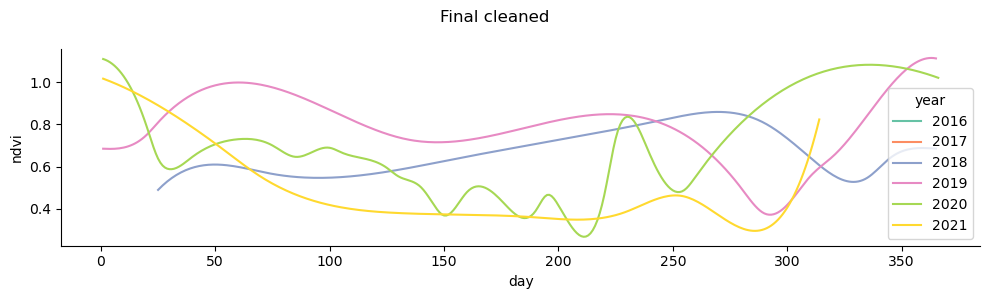

In [291]:
df_smooth = pd.DataFrame()
df_smooth['ts'] = date_range.tolist()
df_smooth['ndvi'] = ynew
df_smooth['year'] = df_smooth['ts'].apply(lambda x: x.year)
df_smooth['day'] = df_smooth['ts'].apply(lambda x: x.dayofyear)


fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Final cleaned')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_smooth, hue='year', palette="Set2")
sns.despine(top=True, right=True)
plt.tight_layout()

In [ ]:
46.663017
6.500186
46.666669
6.493806

In [ ]:
bbox_browning = [6.495, 46.664, 6.497, 46.666] 

In [40]:
bbox_browning = [6.493806, 46.663017, 6.500186, 46.666669] 
#[6.495, 46.664, 6.497, 46.666] 
#[6.49634, 46.66441, 6.49933, 46.66551] 
#[6.48650, 46.66451, 6.49702, 46.67012]  
#[6.47166, 46.65972, 6.50946, 46.67286] 

coords = "46.630_6.379_47.700_6.507"
path_sen = "/dccstor/cimf/drought_impact/downloads/SENTINEL 2/"

folder_path = "/dccstor/cimf/drought_impact/downloads/SENTINEL 2/2018-09-27T00:00:00Z_46.630_6.379_47.700_6.507/"

for file in os.listdir(folder_path):
    if file.endswith('.tiff'):
        if bool(re.search('\[' +  'B02' + '\]',file)): 
            print('Blue')
            with rasterio.open(folder_path+file) as blue_ds:
                blue_band = blue_ds.read(1,  window=from_bounds(bbox_browning[0], bbox_browning[1], bbox_browning[2], bbox_browning[3], blue_ds.transform))
        if bool(re.search('\[' +  'B03' + '\]',file)): 
            print('Green')
            with rasterio.open(folder_path+file) as green_ds:
                green_band = green_ds.read(1,  window=from_bounds(bbox_browning[0], bbox_browning[1], bbox_browning[2], bbox_browning[3], green_ds.transform))
        if bool(re.search('\[' +  'B04' + '\]',file)): 
            print('Red')
            with rasterio.open(folder_path+file) as red_ds:
                red_band = red_ds.read(1,  window=from_bounds(bbox_browning[0], bbox_browning[1], bbox_browning[2], bbox_browning[3], red_ds.transform))
        if bool(re.search('\[' +  'NDVI' + '\]',file)): 
            print('NDVI')
            with rasterio.open(folder_path+file) as ndvi_ds:
                ndvi_band_2018 = ndvi_ds.read(1,  window=from_bounds(bbox_browning[0], bbox_browning[1], bbox_browning[2], bbox_browning[3], ndvi_ds.transform))

Red
NDVI
Green
Blue


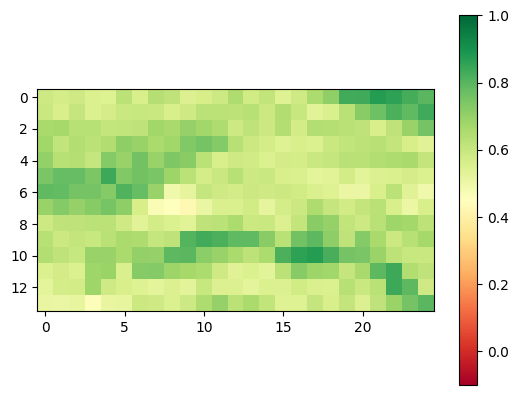

In [41]:
plt.imshow(ndvi_band_2018, vmin=-0.1, vmax=1, cmap='RdYlGn')
plt.colorbar()

# Visualise browning

In [42]:
bbox_browning = [6.493806, 46.663017, 6.500186, 46.666669] #[6.49323, 46.66315, 6.498519, 46.66671] # [6.48650, 46.66451, 6.49702, 46.67012] #[6.49634, 46.66441, 6.49933, 46.66551] #[6.47166, 46.65972, 6.50946, 46.67286] #
coords = "46.630_6.379_47.700_6.507"
path_sen = "/dccstor/cimf/drought_impact/downloads/SENTINEL 2/"
"""
# Schaffhausen
bbox_browning =  [8.64029,47.72969, 8.64370, 47.73234] 
coords = "47.586_8.397_47.807_8.756" # Schaffhausen
"""

'\n# Schaffhausen\nbbox_browning =  [8.64029,47.72969, 8.64370, 47.73234] \ncoords = "47.586_8.397_47.807_8.756" # Schaffhausen\n'

In [43]:
# FInd a date to laod
for folder in os.listdir(path_sen):
    if coords in folder:
        timestamp = folder.split('Z')[0]
        if "2018-08" in timestamp:
            print(timestamp, folder)

2018-08-23T00:00:00 2018-08-23T00:00:00Z_46.630_6.379_47.700_6.507
2018-08-28T00:00:00 2018-08-28T00:00:00Z_46.630_6.379_47.700_6.507
2018-08-03T00:00:00 2018-08-03T00:00:00Z_46.630_6.379_47.700_6.507
2018-08-13T00:00:00 2018-08-13T00:00:00Z_46.630_6.379_47.700_6.507
2018-08-08T00:00:00 2018-08-08T00:00:00Z_46.630_6.379_47.700_6.507
2018-08-18T00:00:00 2018-08-18T00:00:00Z_46.630_6.379_47.700_6.507


In [44]:
# FInd a date to laod
for folder in os.listdir(path_sen):
    if coords in folder:
        timestamp = folder.split('Z')[0]
        if "2019-09" in timestamp:
            print(timestamp, folder)

2019-09-02T00:00:00 2019-09-02T00:00:00Z_46.630_6.379_47.700_6.507
2019-09-17T00:00:00 2019-09-17T00:00:00Z_46.630_6.379_47.700_6.507
2019-09-07T00:00:00 2019-09-07T00:00:00Z_46.630_6.379_47.700_6.507
2019-09-22T00:00:00 2019-09-22T00:00:00Z_46.630_6.379_47.700_6.507
2019-09-12T00:00:00 2019-09-12T00:00:00Z_46.630_6.379_47.700_6.507
2019-09-27T00:00:00 2019-09-27T00:00:00Z_46.630_6.379_47.700_6.507


In [70]:
folder_path = "/dccstor/cimf/drought_impact/downloads/SENTINEL 2/2017-09-27T00:00:00Z_46.630_6.379_47.700_6.507/"
#folder_path = "/dccstor/cimf/drought_impact/downloads/SENTINEL 2/2019-09-27T00:00:00Z_47.586_8.397_47.807_8.756/"


for file in os.listdir(folder_path):
    if file.endswith('.tiff'):
        if bool(re.search('\[' +  'B02' + '\]',file)): 
            print('Blue')
            with rasterio.open(folder_path+file) as blue_ds:
                blue_band = blue_ds.read(1,  window=from_bounds(bbox_browning[0], bbox_browning[1], bbox_browning[2], bbox_browning[3], blue_ds.transform))
        if bool(re.search('\[' +  'B03' + '\]',file)): 
            print('Green')
            with rasterio.open(folder_path+file) as green_ds:
                green_band = green_ds.read(1,  window=from_bounds(bbox_browning[0], bbox_browning[1], bbox_browning[2], bbox_browning[3], green_ds.transform))
        if bool(re.search('\[' +  'B04' + '\]',file)): 
            print('Red')
            with rasterio.open(folder_path+file) as red_ds:
                red_band = red_ds.read(1,  window=from_bounds(bbox_browning[0], bbox_browning[1], bbox_browning[2], bbox_browning[3], red_ds.transform))
        if bool(re.search('\[' +  'NDVI' + '\]',file)): 
            print('NDVI')
            with rasterio.open(folder_path+file) as ndvi_ds:
                ndvi_band_2017 = ndvi_ds.read(1,  window=from_bounds(bbox_browning[0], bbox_browning[1], bbox_browning[2], bbox_browning[3], ndvi_ds.transform))

NDVI
Blue
Green
Red


In [65]:
# Create the RGB composite image
rgb_composite = np.dstack((red_band, green_band, blue_band))
#rgb_composite = rgb_composite.transpose(2,0,1)

"""
# Save the RGB composite image to a file
meta = red_ds.meta.copy()
meta.update(count=3, dtype=rgb_composite.dtype)
with rasterio.open("rgb_composite.tif", "w", **meta) as out_ds:
    out_ds.write(rgb_composite)
"""

'\n# Save the RGB composite image to a file\nmeta = red_ds.meta.copy()\nmeta.update(count=3, dtype=rgb_composite.dtype)\nwith rasterio.open("rgb_composite.tif", "w", **meta) as out_ds:\n    out_ds.write(rgb_composite)\n'

In [66]:
image_norm = (rgb_composite - rgb_composite.min()) / (rgb_composite.max() - rgb_composite.min())

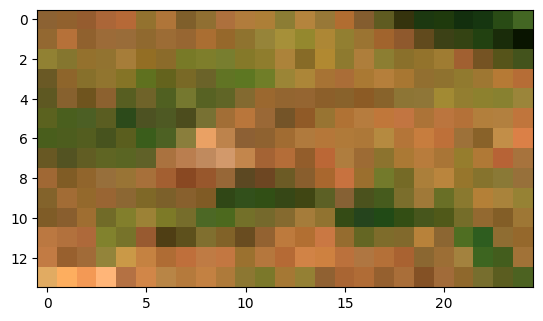

In [62]:
# 2018
plt.imshow(image_norm)

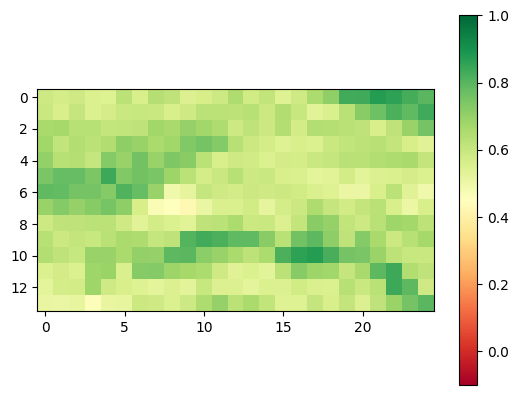

In [63]:
plt.imshow(ndvi_band_2018, vmin=-0.1, vmax=1, cmap='RdYlGn')
plt.colorbar()

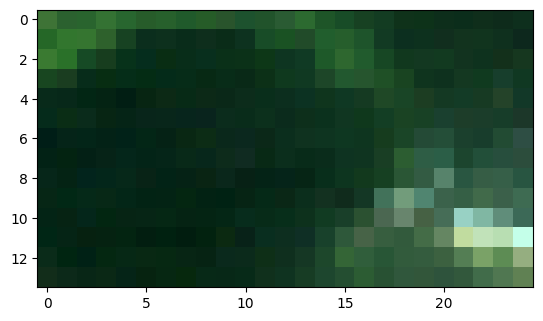

In [67]:
# 2017
plt.imshow(image_norm)

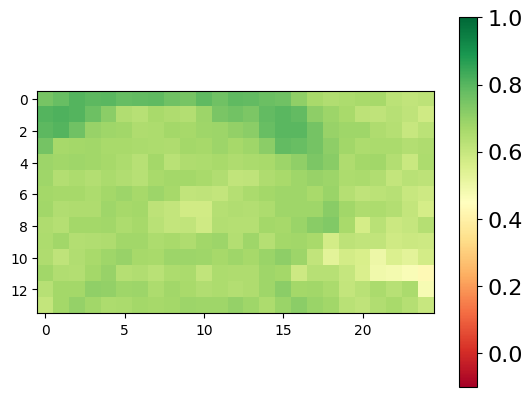

In [71]:
plt.imshow(ndvi_band_2017, vmin=-0.1, vmax=1,cmap='RdYlGn')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16) 

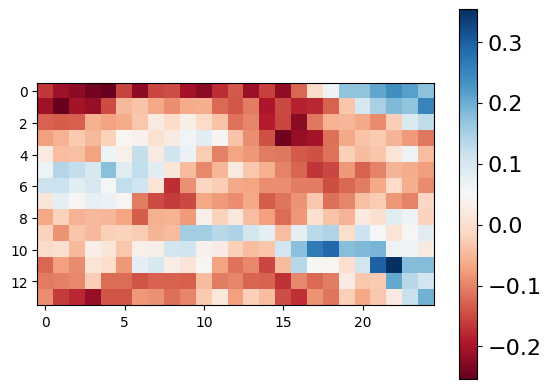

In [72]:
# Difference NDVI 2018 - 2017
plt.imshow(ndvi_band_2018 - ndvi_band_2017, cmap='RdBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16) 

# Timeseries filtering effect (Jura)

In [38]:
# Get a pixel --> find where cp lowest
df_NDVI_brown.groupby('wkt').sum().cp.reset_index().sort_values('cp').head(15)

/tmp/ipykernel_3686809/3913694079.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_NDVI_brown.groupby('wkt').sum().cp.reset_index().sort_values('cp').head(15)


,wkt,cp
7121,POINT (7.394984482758621 47.20423076923077),19227.0
7122,POINT (7.394984482758621 47.20448717948718),19332.0
7054,POINT (7.394728620689655 47.20448717948718),19381.0
6984,POINT (7.394472758620689 47.203974358974364),19403.0
8284,POINT (7.39959 47.20371794871795),19403.0
7188,POINT (7.395240344827586 47.20423076923077),19406.0
6986,POINT (7.394472758620689 47.20448717948718),19429.0
7190,POINT (7.395240344827586 47.20474358974359),19433.0
7123,POINT (7.394984482758621 47.20474358974359),19437.0
7556,POINT (7.396519655172414 47.215),19437.0


In [51]:
df_pix = df_NDVI_brown[df_NDVI_brown.wkt == 'POINT (7.394984482758621 47.20423076923077)']

In [52]:
df_pix_clean = df_pix[(df_pix.b2<0.1) & (df_pix.cp<1)] #
df_pix_cp = df_pix[(df_pix.cp<1)]
#df_pix_clean = df_pix_clean[(df_pix_clean.year>2017)]

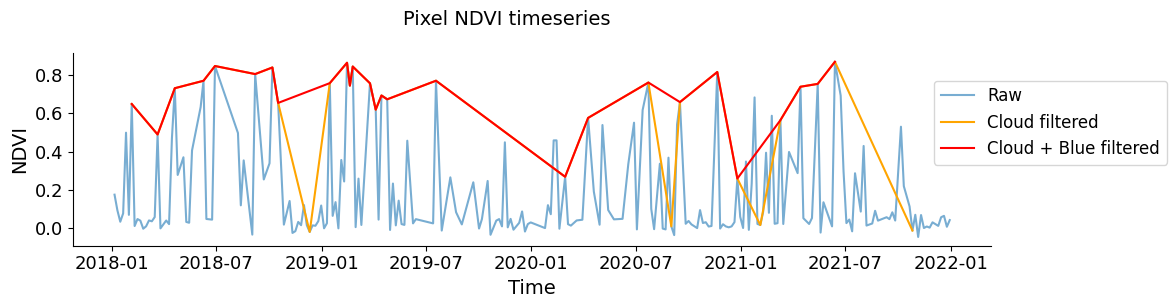

In [61]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Pixel NDVI timeseries',fontsize=14)
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix[df_pix.year>2017], label='Raw', alpha=0.6)
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix_cp[df_pix_cp.year>2017], label='Cloud filtered', color='orange')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix_clean[df_pix_clean.year>2017], label='Cloud + Blue filtered', color='red')
#sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_pix, label='raw') #, alpha=0.5)
sns.despine(top=True, right=True)
plt.tight_layout()
axs.set_xlabel('Time', fontsize=14)
axs.set_ylabel('NDVI', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fontsize=12)